# Logistic Regression - 2005 Moscow Blackout

## Try to downsample the class "normal" (0)

We are going to load the consolidated features for the incident and color the anomaly intervals.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the incident ID (e.g., replace with the relevant identifier)
INCIDENT = "2005-moscow-blackout"  # Replace with the actual incident identifier
COLLECTOR = "rrc05"
WINDOW = "w06s"

# File path for the consolidated features CSV
file_path = f"../features/{INCIDENT}/{WINDOW}/consolidated_features_{COLLECTOR}.csv"

# Load the consolidated features file into merged_df
merged_df = pd.read_csv(file_path)

# Ensure timestamp is parsed as a datetime object
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define anomaly intervals to highlight (as datetime or numeric values)
anomaly_intervals = [
    ("2005-05-24 22:10:09","2005-05-24 22:51:09"),
    ("2005-05-24 23:26:09","2005-05-24 23:52:09"),
    ("2005-05-25 04:24:09","2005-05-25 07:24:09"),
    ("2005-05-25 08:08:09","2005-05-25 09:09:09"),
    ("2005-05-26 19:02:09","2005-05-26 20:44:09")
]

anomaly_intervals

[('2005-05-24 22:10:09', '2005-05-24 22:51:09'),
 ('2005-05-24 23:26:09', '2005-05-24 23:52:09'),
 ('2005-05-25 04:24:09', '2005-05-25 07:24:09'),
 ('2005-05-25 08:08:09', '2005-05-25 09:09:09'),
 ('2005-05-26 19:02:09', '2005-05-26 20:44:09')]

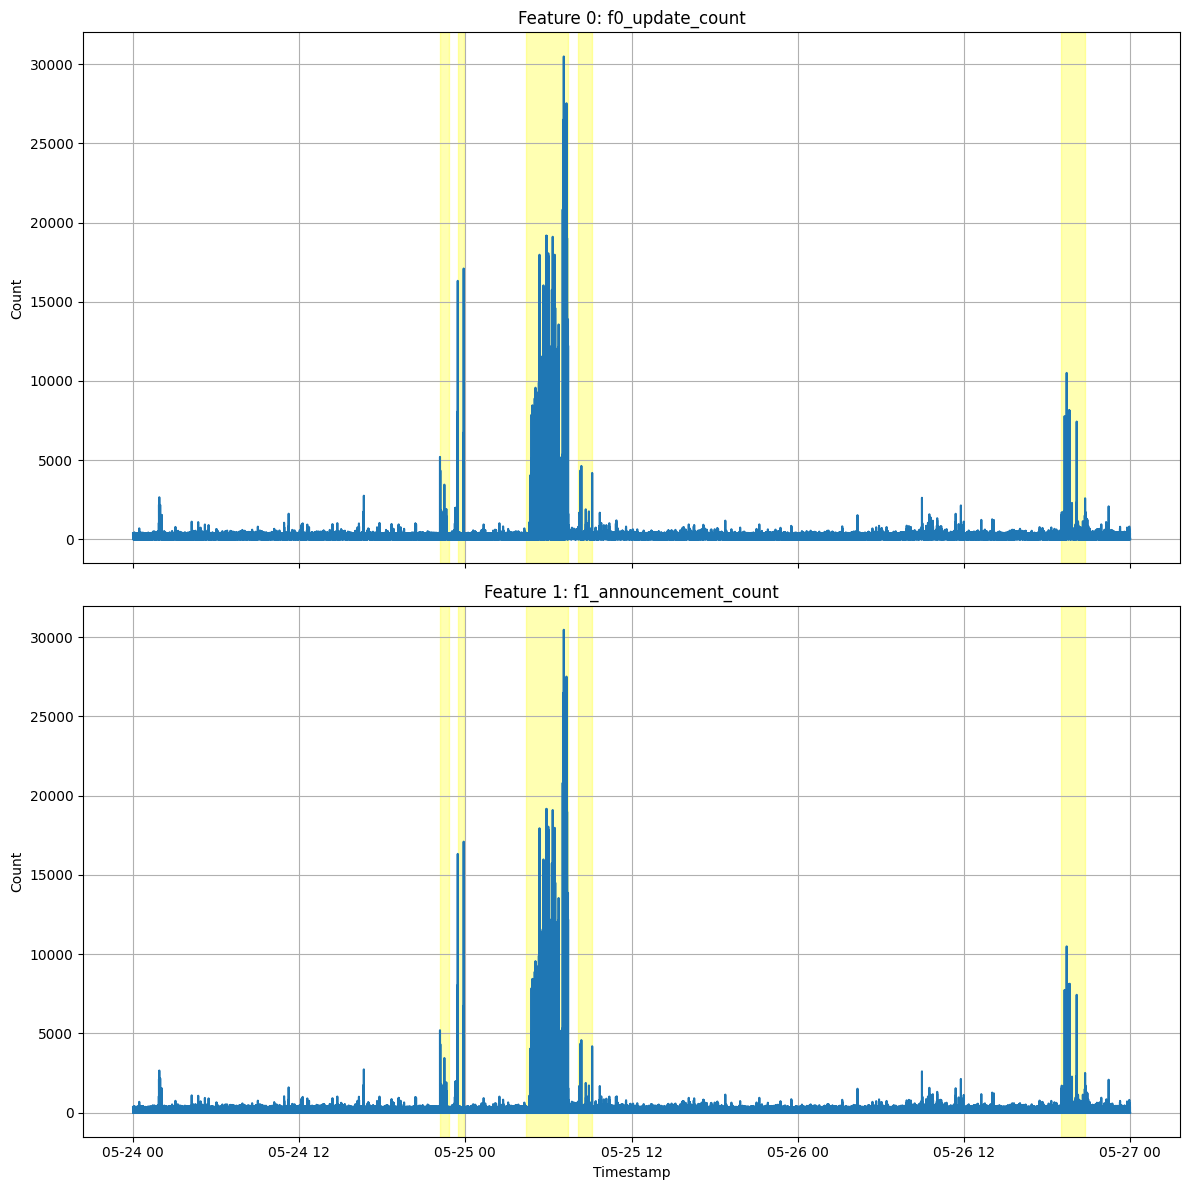

In [2]:
# Plotting
# fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and highlight anomaly intervals
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    
    # Add background highlights for anomalies
    for start, end in anomaly_intervals:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='yellow', alpha=0.3)

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [3]:
# Ensure anomaly_intervals are in datetime format
anomaly_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in anomaly_intervals]

# Create anomaly_df with timestamp column
anomaly_df = pd.DataFrame({'timestamp': merged_df['timestamp']})

# Initialize anomaly column with 0 (no anomaly)
anomaly_df['anomaly'] = 0

# Mark intervals with anomalies as 1
for start, end in anomaly_intervals:
    anomaly_df.loc[(anomaly_df['timestamp'] >= start) & (anomaly_df['timestamp'] <= end), 'anomaly'] = 1

# Preview the resulting dataframe
print(anomaly_df.head())

            timestamp  anomaly
0 2005-05-24 00:00:09        0
1 2005-05-24 00:00:15        0
2 2005-05-24 00:00:21        0
3 2005-05-24 00:00:27        0
4 2005-05-24 00:00:33        0


In [4]:
anomaly_intervals

[(Timestamp('2005-05-24 22:10:09'), Timestamp('2005-05-24 22:51:09')),
 (Timestamp('2005-05-24 23:26:09'), Timestamp('2005-05-24 23:52:09')),
 (Timestamp('2005-05-25 04:24:09'), Timestamp('2005-05-25 07:24:09')),
 (Timestamp('2005-05-25 08:08:09'), Timestamp('2005-05-25 09:09:09')),
 (Timestamp('2005-05-26 19:02:09'), Timestamp('2005-05-26 20:44:09'))]

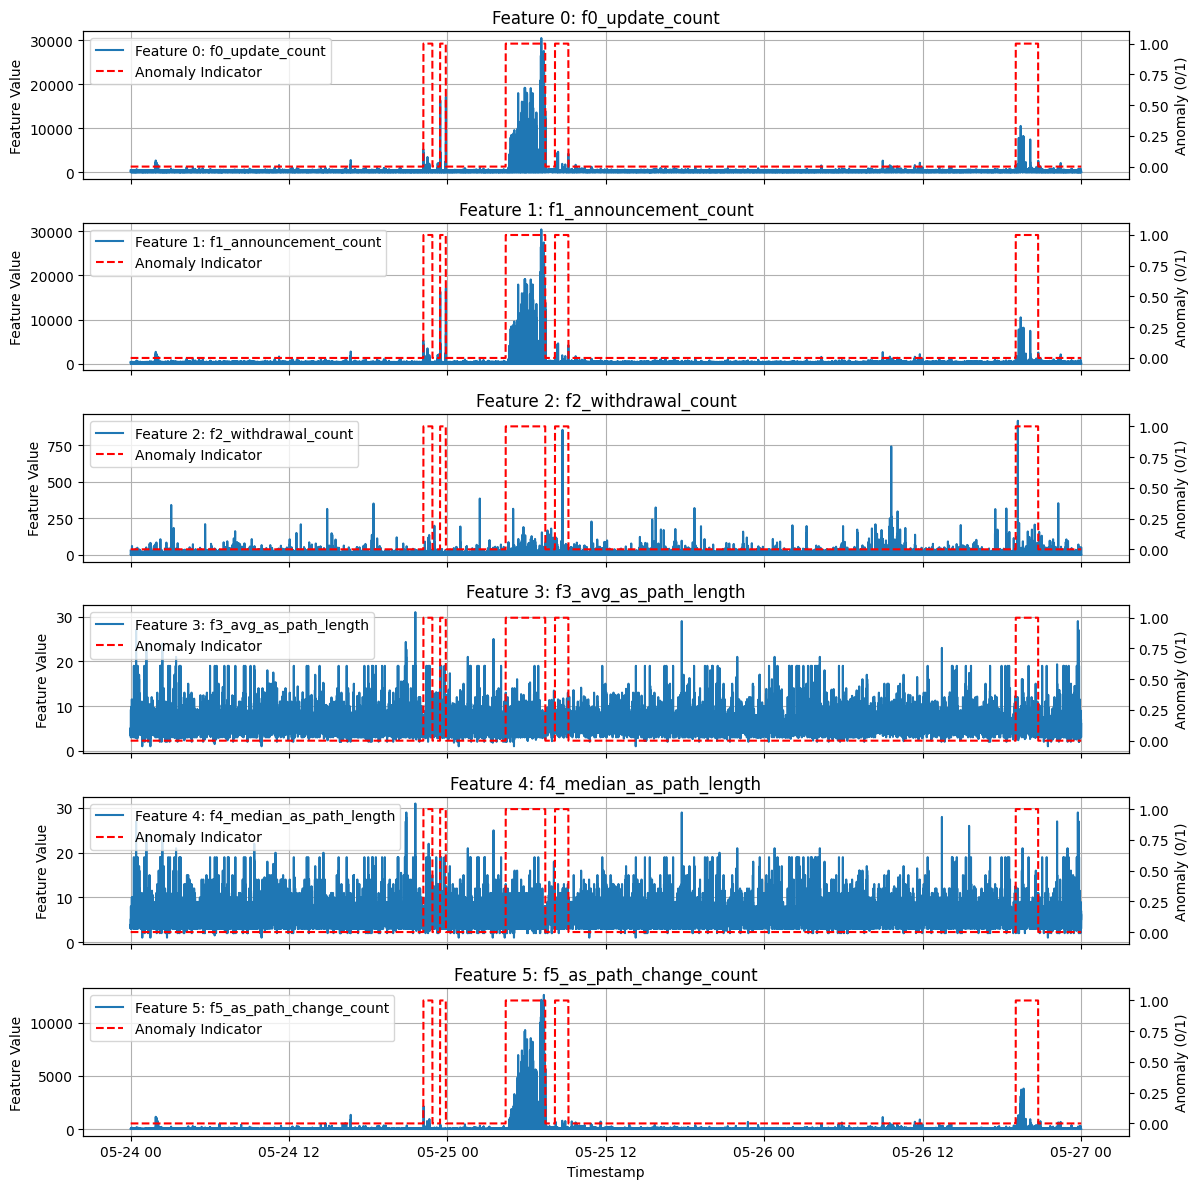

In [5]:
### -------------------------------------------
# Plotting
fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and overlay the anomaly indicator
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    # Plot the feature
    ax.plot(merged_df['timestamp'], merged_df[col], label=f"Feature {i}: {col}")
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Feature Value")
    ax.grid(True)
    
    # Add the anomaly indicator on a secondary Y-axis
    ax2 = ax.twinx()
    ax2.plot(anomaly_df['timestamp'], anomaly_df['anomaly'], color='red', linestyle='--', label="Anomaly Indicator")
    ax2.set_ylabel("Anomaly (0/1)")
    ax2.set_ylim(-0.1, 1.1)  # Ensure the anomaly values fit well visually
    
    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="upper left")

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Split datasets

We will split our data into training and validation sets.

In [6]:
# Convert timestamps to a NumPy array before shuffling
timestamps = np.array(merged_df['timestamp'].unique())  # Explicitly convert to NumPy array
TRAINING_SPLIT = 0.75

# Shuffle timestamps and split according TRAINING_SPLIT
np.random.seed(42)  # fix seed for reproducibility
np.random.shuffle(timestamps)

# Split timestamps into training and validation sets
split_index = int(TRAINING_SPLIT * len(timestamps))
train_timestamps = timestamps[:split_index]
val_timestamps = timestamps[split_index:]

# Split the data based on the sampled timestamps
train_features = merged_df[merged_df['timestamp'].isin(train_timestamps)]
val_features = merged_df[merged_df['timestamp'].isin(val_timestamps)]

train_labels = anomaly_df[anomaly_df['timestamp'].isin(train_timestamps)]
val_labels = anomaly_df[anomaly_df['timestamp'].isin(val_timestamps)]

# Verify timestamps
print("Training Range:", train_features["timestamp"].min(), "to", train_features["timestamp"].max())
print("Validation Range:", val_features["timestamp"].min(), "to", val_features["timestamp"].max())
print("Full Range:", merged_df["timestamp"].min(), "to", merged_df["timestamp"].max())

# Reset indices for clean DataFrames
train_features = train_features.reset_index(drop=True)
val_features = val_features.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Verify split sizes
print("Training Features Shape:", train_features.shape)
print("Validation Features Shape:", val_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)


Training Range: 2005-05-24 00:00:09 to 2005-05-26 23:59:57
Validation Range: 2005-05-24 00:00:21 to 2005-05-26 23:59:45
Full Range: 2005-05-24 00:00:09 to 2005-05-26 23:59:57
Training Features Shape: (32399, 7)
Validation Features Shape: (10800, 7)
Training Labels Shape: (32399, 2)
Validation Labels Shape: (10800, 2)


## Train a logistic regressor

Train a logistic regressor with our data and validate it.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare training and validation data
X_train = train_features.drop(columns=["timestamp"])  # Drop timestamp column for features
X_val = val_features.drop(columns=["timestamp"])

y_train = train_labels["anomaly"]  # Use the anomaly column as the target
y_val = val_labels["anomaly"]

# Train the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

# Evaluation
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:\n", conf_matrix)


Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     29324
           1       0.88      0.11      0.20      3075

    accuracy                           0.91     32399
   macro avg       0.90      0.55      0.58     32399
weighted avg       0.91      0.91      0.88     32399

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      9770
           1       0.87      0.13      0.22      1030

    accuracy                           0.92     10800
   macro avg       0.89      0.56      0.59     10800
weighted avg       0.91      0.92      0.89     10800

Validation Confusion Matrix:
 [[9750   20]
 [ 898  132]]


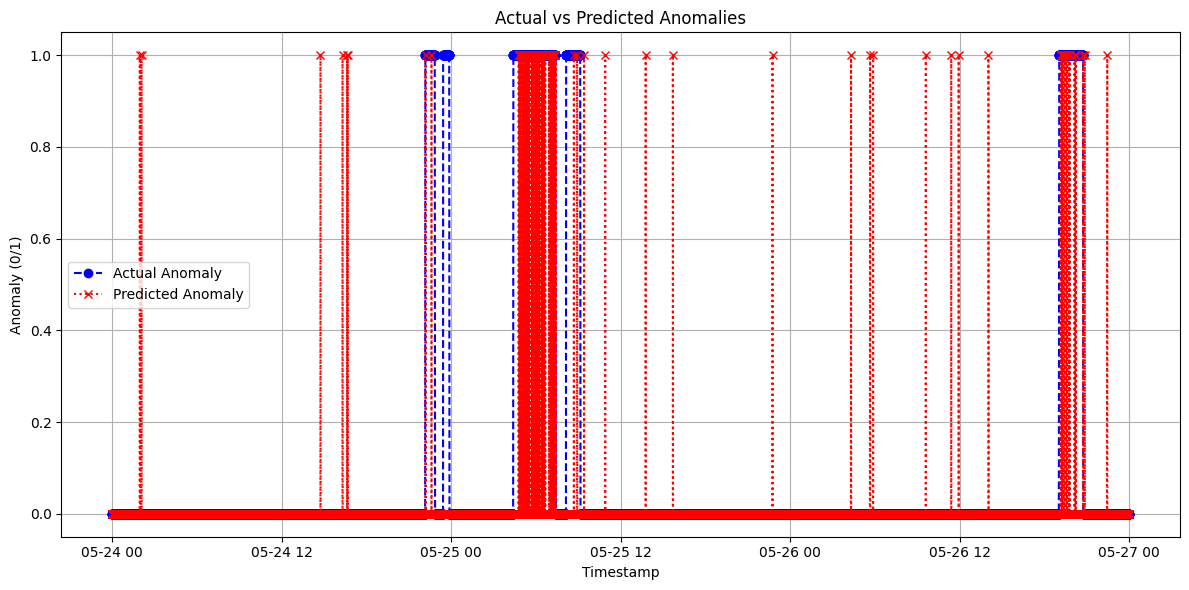

In [8]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 6))
plt.plot(val_features["timestamp"], y_val, label="Actual Anomaly", color="blue", marker='o', linestyle="--")
plt.plot(val_features["timestamp"], y_val_pred, label="Predicted Anomaly", color="red", marker='x', linestyle=":")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (0/1)")
plt.title("Actual vs Predicted Anomalies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
val_features.head()

,timestamp,f0_update_count,f1_announcement_count,f2_withdrawal_count,f3_avg_as_path_length,f4_median_as_path_length,f5_as_path_change_count
0,2005-05-24 00:00:21,5,3,1.0,3.333333,3.0,2
1,2005-05-24 00:01:03,342,331,5.0,5.138973,5.0,13
2,2005-05-24 00:01:09,37,34,1.0,6.382353,5.0,15
3,2005-05-24 00:01:21,17,14,1.0,4.142857,4.0,5
4,2005-05-24 00:01:45,43,21,7.0,5.619048,5.0,10


## Try downsampling the majority class

In [10]:
from sklearn.utils import resample

# Combine features and labels for easier downsampling
train_data = train_features.merge(train_labels, on="timestamp")

# Separate majority and minority classes
majority_class = train_data[train_data['anomaly'] == 0]
minority_class = train_data[train_data['anomaly'] == 1]

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # Sample without replacement
    n_samples=len(minority_class)*4,  # Match minority class size
    random_state=42  # For reproducibility
)

# Combine downsampled majority class with minority class
balanced_train_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the data to mix the classes
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate back into features and labels
train_features_balanced = balanced_train_data.drop(columns=['anomaly'])
train_labels_balanced = balanced_train_data[['timestamp', 'anomaly']]

# Verify class distribution
print("Balanced Training Class Distribution:\n", train_labels_balanced['anomaly'].value_counts())


Balanced Training Class Distribution:
 anomaly
0    12300
1     3075
Name: count, dtype: int64


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the features and labels for training
X_train_balanced = train_features_balanced.drop(columns=["timestamp"])  # Drop timestamp for training
y_train_balanced = train_labels_balanced["anomaly"]  # Use the anomaly column as the target

X_val = val_features.drop(columns=["timestamp"])  # Validation features
y_val = val_labels["anomaly"]  # Validation labels

# Train the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

# Make predictions on both training and validation sets
y_train_pred = log_reg.predict(X_train_balanced)
y_val_pred = log_reg.predict(X_val)

# Evaluation on training set
print("Training Classification Report:\n", classification_report(y_train_balanced, y_train_pred))

# Evaluation on validation set
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:\n", conf_matrix)


Training Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90     12300
           1       0.86      0.14      0.24      3075

    accuracy                           0.82     15375
   macro avg       0.84      0.57      0.57     15375
weighted avg       0.83      0.82      0.77     15375

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      9770
           1       0.77      0.16      0.26      1030

    accuracy                           0.92     10800
   macro avg       0.84      0.58      0.61     10800
weighted avg       0.90      0.92      0.89     10800

Validation Confusion Matrix:
 [[9721   49]
 [ 868  162]]


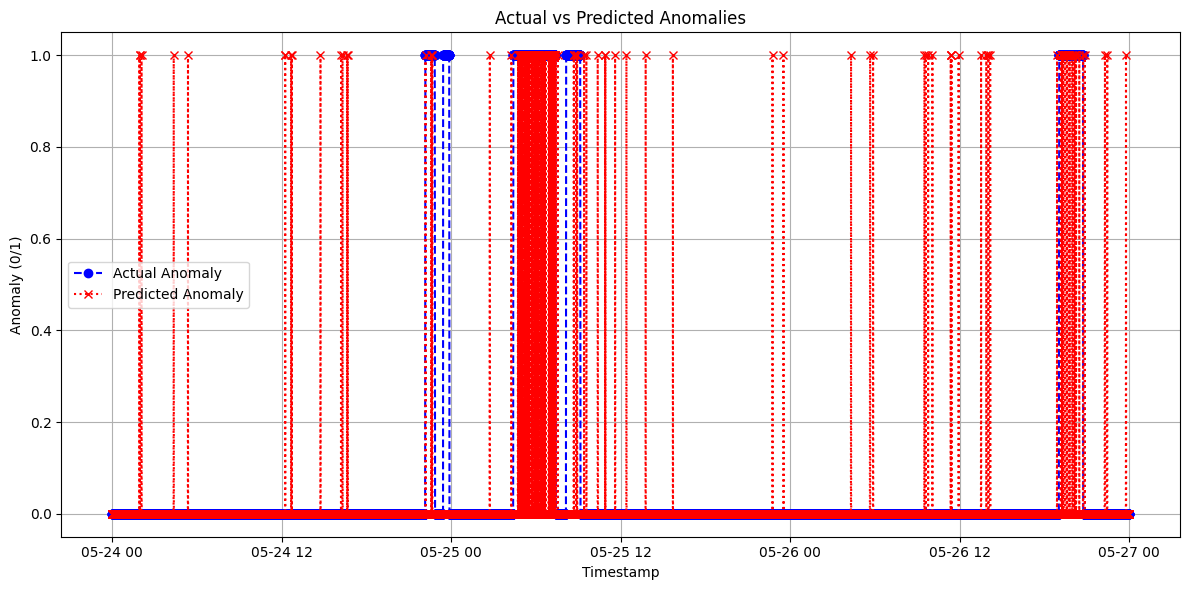

In [12]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 6))
plt.plot(val_features["timestamp"], y_val, label="Actual Anomaly", color="blue", marker='o', linestyle="--")
plt.plot(val_features["timestamp"], y_val_pred, label="Predicted Anomaly", color="red", marker='x', linestyle=":")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (0/1)")
plt.title("Actual vs Predicted Anomalies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Try setting a custom threshold

Validation Classification Report (Threshold = 0.7):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      9770
           1       0.84      0.14      0.23      1030

    accuracy                           0.92     10800
   macro avg       0.88      0.57      0.59     10800
weighted avg       0.91      0.92      0.89     10800

Validation Confusion Matrix (Threshold = 0.7):
 [[9744   26]
 [ 890  140]]


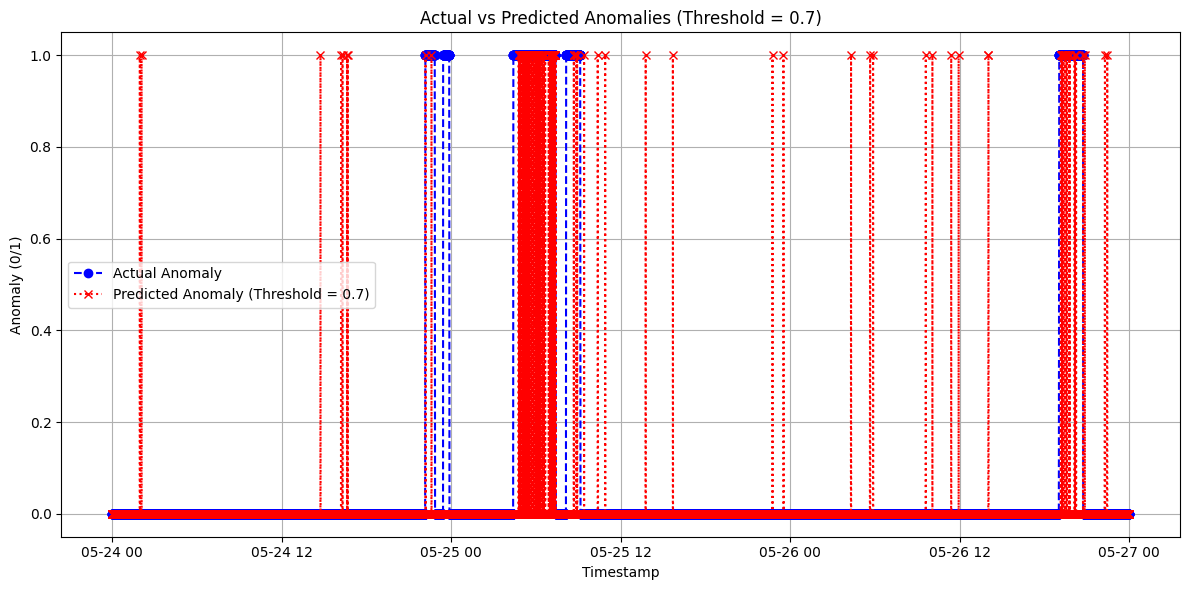

In [13]:
# Set a custom threshold (e.g., 0.7)
custom_threshold = 0.7

# Get predicted probabilities for the validation set
y_val_prob = log_reg.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class (anomaly = 1)

# Apply the custom threshold
y_val_pred_custom = (y_val_prob >= custom_threshold).astype(int)

# Evaluation with custom threshold
print(f"Validation Classification Report (Threshold = {custom_threshold}):\n",
      classification_report(y_val, y_val_pred_custom))

# Confusion matrix for custom threshold
conf_matrix_custom = confusion_matrix(y_val, y_val_pred_custom)
print(f"Validation Confusion Matrix (Threshold = {custom_threshold}):\n", conf_matrix_custom)

# Plot actual vs predicted with custom threshold
plt.figure(figsize=(12, 6))
plt.plot(val_features["timestamp"], y_val, label="Actual Anomaly", color="blue", marker='o', linestyle="--")
plt.plot(val_features["timestamp"], y_val_pred_custom, label=f"Predicted Anomaly (Threshold = {custom_threshold})",
         color="red", marker='x', linestyle=":")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (0/1)")
plt.title(f"Actual vs Predicted Anomalies (Threshold = {custom_threshold})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Decision Trees

In [14]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X_train.head()

,f0_update_count,f1_announcement_count,f2_withdrawal_count,f3_avg_as_path_length,f4_median_as_path_length,f5_as_path_change_count
0,391,354,29.0,4.901130,5.0,16
1,8,5,1.0,3.600000,3.0,2
2,24,20,1.0,4.650000,4.0,10
3,62,57,1.0,5.140351,4.0,18
4,24,21,1.0,4.333333,4.0,16


In [15]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: anomaly, dtype: int64

In [16]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)

# Train Decision Tree Classifer
clf = clf.fit(X_train_balanced,y_train_balanced)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [17]:
# Evaluate Decision Tree
print(f"Validation Classification Report for Decision Tree:\n\n",
      classification_report(y_val, y_pred))

Validation Classification Report for Decision Tree:

               precision    recall  f1-score   support

           0       0.92      0.99      0.95      9770
           1       0.68      0.17      0.28      1030

    accuracy                           0.91     10800
   macro avg       0.80      0.58      0.62     10800
weighted avg       0.90      0.91      0.89     10800



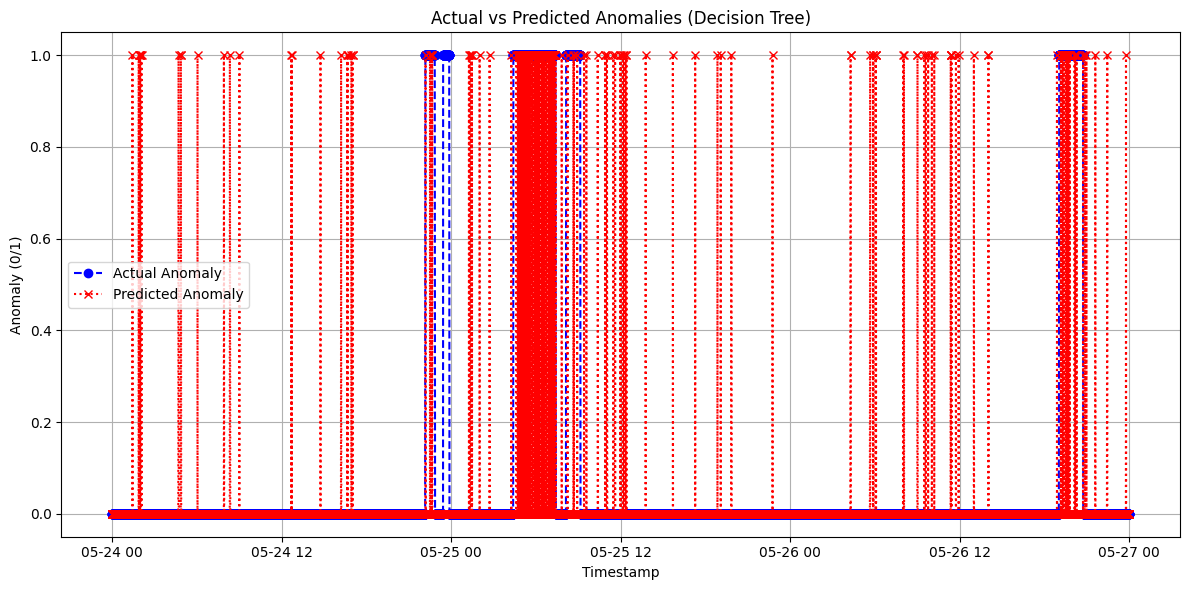

In [18]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 6))
plt.plot(val_features["timestamp"], y_val, label="Actual Anomaly", color="blue", marker='o', linestyle="--")
plt.plot(val_features["timestamp"], y_pred, label="Predicted Anomaly", color="red", marker='x', linestyle=":")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly (0/1)")
plt.title("Actual vs Predicted Anomalies (Decision Tree)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
